#Бизнес-задачи проекта
Бизнес задачами данного проекта являются создание продукта для предсказания цен на ОН г.Краснодар а также их распределение на подкатегории (классификация посредством кластеризации) для удобства в дальнейшем использовании
#Этапы:
1. Поиск и подготовка данных для последующего создания модели предсказания цен на недвижимость и классификации
2. Создание и испытание нескольких моделей предсказания цен создание и испытание модели кластеризации.
3. Оценка качества предсказаний моделей и выбор наиболее актуальной
4. Развертывание и дальнейшее усовершенствование продукта. 


##1. Этап. Поиск и подготовка данных. 
На данном этапе был отобран датасет цен на недвижимость России. В этом разделе будут приведены операции направленные на анализ и очистку данных, их подготовка для использования на последующих шагах.

In [1]:
# Загрузим необходимые библиотеки:
import pandas as pd
import csv
from geopy.geocoders import Nominatim
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.cluster import KMeans
import geopy.distance

In [2]:
# Подключим гугл диск:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Загрузим наш датасет:
df = pd.read_csv('/content/drive/MyDrive/final_project/all_v1.csv')

In [4]:
# Давайте рассмотрим наш датасет и описание к нему:
df.head()

,price,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,17000000,00:01:54,55.803096,37.557713,3,4,2,5,3,78.0,8.4,1
1,14093440,00:03:48,55.815317,37.426025,3,2,9,24,2,60.8,21.3,11
2,3800000,00:05:07,54.744539,20.484014,7896,3,14,17,1,43.0,10.0,1
3,9428200,00:06:26,55.880344,37.501306,3,2,26,33,2,59.0,19.3,11
4,21339360,00:06:29,55.812833,37.601419,3,2,24,32,4,116.8,17.1,11


Контекст Набор данных состоит из списков уникальных объектов популярных порталов по продаже недвижимости в России. 



Набор данных Набор данных имеет 12 полей.

######время - время публикации объявления; 
#####geo_lat - Широта 
#####geo_lon - Долгота 
#####region - Регион России. Всего в стране 85 субъектов. 
#####building_type - Тип фасада. 0 - Другое. 1 - Панель. 2 - Монолитный. 3 - Кирпич. 4 - Блочный. 5 - Деревянный. 
#####object_type - Тип квартиры. 1 - Вторичный рынок недвижимости; 11 - Новостройка; 
#####level - этаж квартиры, 
#####levels-количество этажей в доме 
#####rooms - Количество жилых комнат. Если значение "-1", то это означает "квартира-студия" 
#####area - общая площадь квартиры 
#####kitchen_area - площадь кухни, 
#####price - цена. в рублях 
Внимание. Набор данных может содержать ошибочные данные из-за ошибок ввода на сервисах, а также выбросы и так далее.
#####опытным путем установлено, что краснодарскому краю соответствует значение region=2843, также установлены координаты крайних точек города. Дальнейшая аналитика будет производиться внутри этих четырех координат, что будет соответствовать координатам г.Кранодар.
##### Краснодар 45.078330, 39.384660 (Центр города)
#####45.066893, 38.648404;  45.204197, 39.011915;  44.969132, 39.023347; 45.046784, 38.981795 .

In [5]:
# Произведем фильтрацию данных, после удалим столбцы time, и region которые нам не потребуется
df = df[df['region'] == 2843].copy()
df.drop(['region', 'time'], axis=1, inplace=True)

In [6]:
# Ограничим область рассмотрения крайними точками координат города и ближайшего пригорода
# Создание экземпляра класса Nominatim
geolocator = Nominatim(user_agent="myGeocoder")

# Определение координат точек
point1 = (45.058657, 39.211959)
point2 = (45.052472, 38.884735)
point3 = (45.146044, 38.999977)
point4 = (44.969132, 39.023347)

# Определение границ прямоугольника
min_lat = min(point1[0], point2[0], point3[0], point4[0])
max_lat = max(point1[0], point2[0], point3[0], point4[0])
min_lon = min(point1[1], point2[1], point3[1], point4[1])
max_lon = max(point1[1], point2[1], point3[1], point4[1])

# Фильтрация данных в датафрейме по координатам
df = df[(df['geo_lat'] >= min_lat) & (df['geo_lat'] <= max_lat) & (df['geo_lon'] >= min_lon) & (df['geo_lon'] <= max_lon)]

In [7]:
# Теперь давайте проверим уникальные значения в колонках
print("Уникальные значения building_type:", df['building_type'].unique())
print("Уникальные значения level:", df['level'].unique())
print("Уникальные значения levels:", df['levels'].unique())
print("Уникальные значения rooms:", df['rooms'].unique())
print("Уникальные значения object_type:", df['object_type'].unique())
# Я вижу значение -2, в столбце rooms, о котором нет информации в описании к датасету, поэтому строки с этим значением удаляю.

Уникальные значения building_type: [2 3 1 4 0 5]
Уникальные значения level: [ 4  6  1 16  8 20  2  7 12  5  3 11 19 18 14 17 10  9 15 13 25 23 21 22
 24]
Уникальные значения levels: [13 18  4  9  5 22  3 23  6 10 12  8 17 24 16 11 14 19 15 25 21 20  7  1
  2 26 28 27 34]
Уникальные значения rooms: [ 2  1  3  4 -1  6  5  7 -2  9]
Уникальные значения object_type: [ 1 11]


In [8]:
df = df.loc[df['rooms'] != -2]

In [9]:
print("Уникальные значения rooms:", df['rooms'].unique())
#Теперь все в порядке

Уникальные значения rooms: [ 2  1  3  4 -1  6  5  7  9]


In [10]:
#Проверим наш датасет на дубликаты:(до проверки было 26041строк, после проверки 24862)
df = df.drop_duplicates()

In [11]:
# И на пустые значения:
df.isnull().sum()

price            0
geo_lat          0
geo_lon          0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
dtype: int64

In [12]:
df.head()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type
239,4550000,45.072351,38.951696,2,4,13,2,63.0,26.00,1
261,2170000,45.070976,39.040648,3,6,18,1,26.9,6.51,1
279,2800000,45.030533,39.006015,3,1,4,2,62.0,12.50,1
281,5650000,45.054054,39.017705,3,16,18,2,61.0,11.00,1
357,2700000,45.004044,39.070161,1,8,9,2,43.7,8.00,1


In [13]:
#методом межквартильного размаха  с использованием пороговых значений, установим и удалим выбросы.
# Вычисление межквартильного размаха (IQR) для столбца 'price'
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Определение выбросов на основе порога IQR (например, Q1 - 1.5 * IQR или Q3 + 1.5 * IQR)
price_выбросы = df[(df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))]
df = df.drop(price_выбросы.index)

In [14]:
# Вычисление межквартильного размаха (IQR) для столбца 'kitchen_area'
Q1 = df['kitchen_area'].quantile(0.25)
Q3 = df['kitchen_area'].quantile(0.75)
IQR = Q3 - Q1

# Определение выбросов на основе порога IQR (например, Q1 - 1.5 * IQR или Q3 + 1.5 * IQR)
kitchen_area_выбросы = df[(df['kitchen_area'] < (Q1 - 1.5 * IQR)) | (df['kitchen_area'] > (Q3 + 1.5 * IQR))]
df = df.drop(kitchen_area_выбросы.index)

In [15]:
# Вычисление межквартильного размаха (IQR) для столбца 'area'
Q1 = df['area'].quantile(0.25)
Q3 = df['area'].quantile(0.75)
IQR = Q3 - Q1

# Определение выбросов на основе порога IQR (например, Q1 - 1.5 * IQR или Q3 + 1.5 * IQR)
area_выбросы = df[(df['area'] < (Q1 - 1.5 * IQR)) | (df['area'] > (Q3 + 1.5 * IQR))]
df = df.drop(area_выбросы.index)

Вывод: На данном этапе мы провели поиск и подготовку данных. Выявили необходимые данные, провели их проверку и очистку а также подготовили наш датасет к дальнейшей работе. 

##2 Этап. Создание и испытание нескольких моделей предсказания цен
На данном этапе созданы несколько моделей машинного обучения для предсказания цен и также нейронная сеть для предсказаний. Подготовлены результаты для дальнейшего сравнения и выбора наиболее актуальной модели предсказания. Для дальнейшего сравнения модели обучались на масштабированных и немасштабированных данных 

<Axes: >

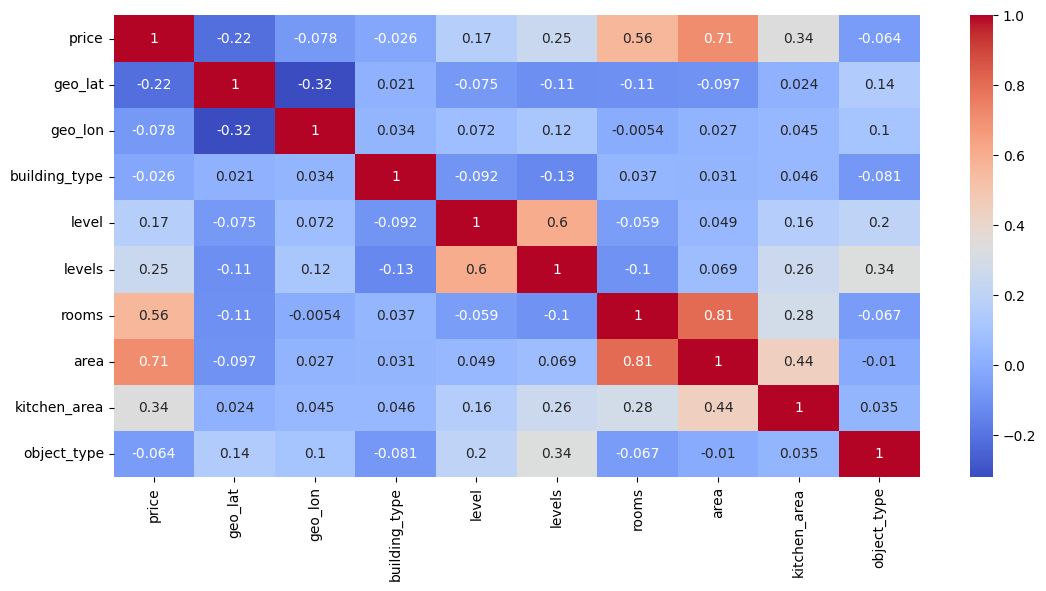

In [16]:
# Построение матрицы корреляции с использованием немасштабированных значений
correlation_matrix = df.corr()

# Создание тепловой карты
plt.figure(figsize=(13,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
#Мы видим, что цена наиболее сильно кореллирует с количеством комнат и площадью, также очевидна взаимосвязь с параметром "geo_lat"

In [17]:
#Масшатбабирование данных методом StandardScaler
scaler = StandardScaler()
scaled_df  = scaler.fit_transform(df)
df_StandardScaler = pd.DataFrame(scaled_df, columns=df.columns)

In [18]:
#Масшатбабирование данных методом MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
df_MinMaxScaler = pd.DataFrame(scaled_df, columns=df.columns)

In [19]:
# разделение данных на тренировочные и тестовые
X = df.drop(['price'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# создание и компиляция модели нейронной сети
nr = Sequential()
nr.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
nr.add(Dense(128, activation='relu'))
nr.add(Dense(32, activation='relu'))
nr.add(Dense(16, activation='relu'))
nr.add(Dense(1))
nr.compile(loss='mean_squared_error', optimizer='adam')

# обучение модели нейронной сети
nr.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# оценка качества предсказаний нейронной сети
y_pred_nr = nr.predict(X_test).reshape(-1)
mse_nr = mean_squared_error(y_test, y_pred_nr)
r2_nr = r2_score(y_test, y_pred_nr)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# обучение модели с EarlyStopping и валидационной выборкой
history = nr.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[es])

# обучение модели линейной регрессии
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# обучение модели случайного леса
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# обучение модели решающего дерева
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

140/140 [==============================] - 1s 7ms/step
Epoch 25: early stopping


In [20]:
# вывод результатов
print('Linear Regression MSE:', mse_lr, 'R^2:', r2_lr)
print('Random Forest MSE:', mse_rf, 'R^2:', r2_rf)
print('Decision Tree MSE:', mse_dt, 'R^2:', r2_dt)
print('Neural Network MSE:', mse_nr, 'R^2:', r2_nr)

Linear Regression MSE: 597541653418.7277 R^2: 0.5843799128446566
Random Forest MSE: 358082082326.8305 R^2: 0.7509360135582813
Decision Tree MSE: 701638712774.4359 R^2: 0.5119752049309867
Neural Network MSE: 653713817752.7781 R^2: 0.5453093648708867


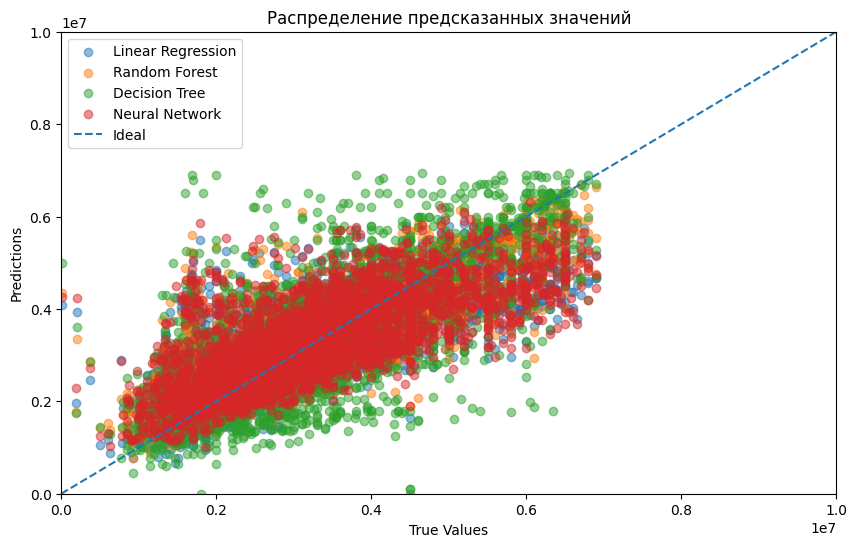

In [21]:
# построение графика результатов
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.scatter(y_test, y_pred_dt, alpha=0.5, label='Decision Tree')
plt.scatter(y_test, y_pred_nr, alpha=0.5, label='Neural Network')
plt.plot([0, 10_000_000], [0, 10_000_000], linestyle='--', label='Ideal')
plt.xlim(0, 10_000_000)
plt.ylim(0, 10_000_000)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Распределение предсказанных значений')
plt.show()

In [22]:
# разделение данных на тренировочные и тестовые
X1 = df_MinMaxScaler.drop(['price'], axis=1)
y1 = df_MinMaxScaler['price']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# создание и компиляция модели нейронной сети
nr1 = Sequential()
nr1.add(Dense(512, input_dim=X1_train.shape[1], activation='relu'))
nr1.add(Dense(128, activation='relu'))
nr1.add(Dense(32, activation='relu'))
#nr1.add(Dropout(0.2))
nr1.add(Dense(16, activation='relu'))
nr1.add(Dense(1))
nr1.compile(loss='mean_squared_error', optimizer='adam')

# использование EarlyStopping для остановки обучения, если ошибка на валидационной выборке перестанет уменьшаться
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# обучение модели с EarlyStopping и валидационной выборкой
history = nr1.fit(X1_train, y1_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[es])

# оценка качества предсказаний нейронной сети
y1_pred_nr1 = nr1.predict(X1_test).reshape(-1)
mse_nr1 = mean_squared_error(y1_test, y1_pred_nr1)
r2_nr1 = r2_score(y1_test, y1_pred_nr1)

# обучение модели линейной регрессии
lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)
y1_pred_lr1 = lr1.predict(X1_test)
mse_lr1 = mean_squared_error(y1_test, y1_pred_lr1)
r2_lr1 = r2_score(y1_test, y1_pred_lr1)

# обучение модели случайного леса
rf1 = RandomForestRegressor(random_state=42)
rf1.fit(X1_train, y1_train)
y1_pred_rf1 = rf1.predict(X1_test)
mse_rf1 = mean_squared_error(y1_test, y1_pred_rf1)
r2_rf1 = r2_score(y1_test, y1_pred_rf1)

# обучение модели решающего дерева
dt1 = DecisionTreeRegressor(random_state=42)
dt1.fit(X1_train, y1_train)
y1_pred_dt1 = dt1.predict(X1_test)
mse_dt1 = mean_squared_error(y1_test, y1_pred_dt1)
r2_dt1 = r2_score(y1_test, y1_pred_dt1)

Epoch 64: early stopping
140/140 [==============================] - 3s 20ms/step


In [23]:
# вывод результатов
print('Linear Regression MSE:', mse_lr1, 'R^2:', r2_lr1)
print('Random Forest MSE:', mse_rf1, 'R^2:', r2_rf1)
print('Decision Tree MSE:', mse_dt1, 'R^2:', r2_dt1)
print('Neural Network MSE:', mse_nr1, 'R^2:', r2_nr1)

Linear Regression MSE: 0.012306285038987834 R^2: 0.5843799128446554
Random Forest MSE: 0.0073729255223146046 R^2: 0.7509942327464328
Decision Tree MSE: 0.013957943007019096 R^2: 0.528598478687298
Neural Network MSE: 0.00940979192613403 R^2: 0.6822031565120366


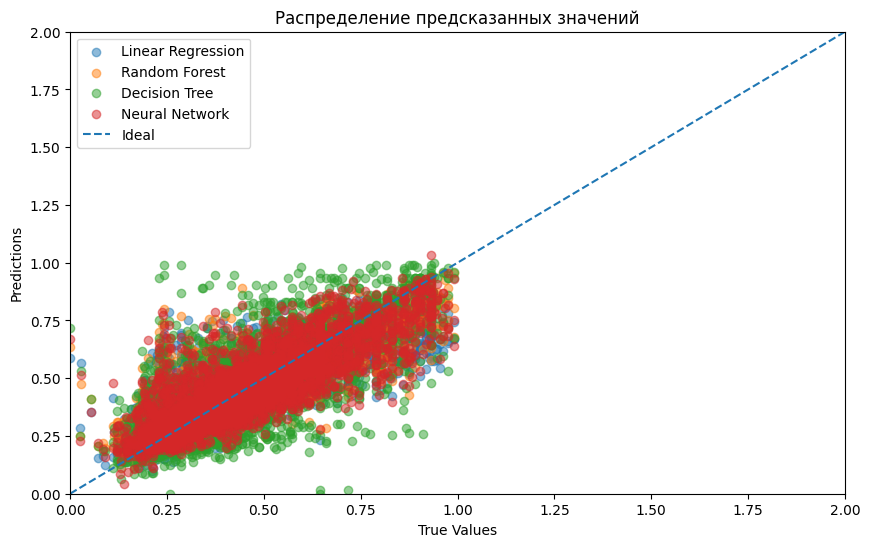

In [24]:
# построение графика результатов
plt.figure(figsize=(10, 6))
plt.scatter(y1_test, y1_pred_lr1, alpha=0.5, label='Linear Regression')
plt.scatter(y1_test, y1_pred_rf1, alpha=0.5, label='Random Forest')
plt.scatter(y1_test, y1_pred_dt1, alpha=0.5, label='Decision Tree')
plt.scatter(y1_test, y1_pred_nr1, alpha=0.5, label='Neural Network')
plt.plot([0, 2], [0, 2], linestyle='--', label='Ideal')
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Распределение предсказанных значений')
plt.show()


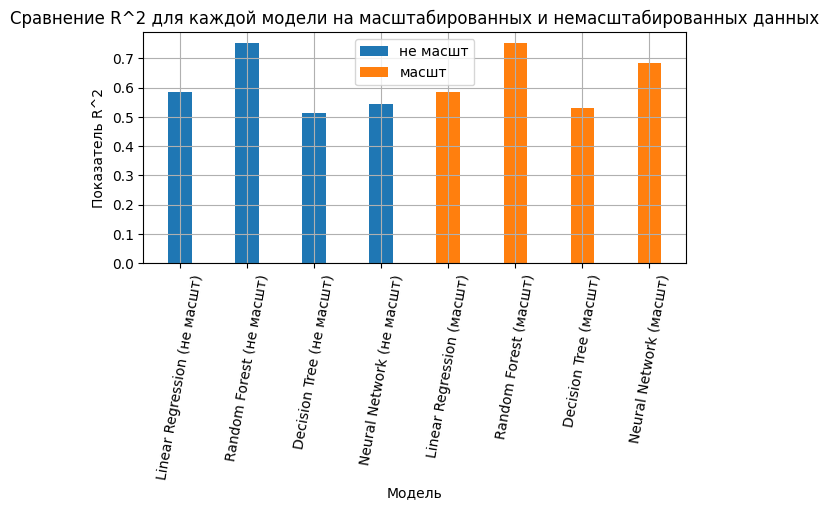

In [25]:
# Создаем списки значений R^2 для каждой модели на не масштабированных данных
r2_list_unscaled = [r2_lr, r2_rf, r2_dt, r2_nr]

# Создаем списки значений R^2 для каждой модели на масштабированных данных
r2_list_scaled = [r2_lr1, r2_rf1, r2_dt1, r2_nr1]

# Список названий моделей
model_names = ['Linear Regression', 'Random Forest', 'Decision Tree', 'Neural Network']

# Создаем график
fig, ax = plt.subplots()

# Определяем ширину столбцов гистограммы
width = 0.35

# Создаем столбчатые гистограммы для каждой модели
rects1 = ax.bar([name + ' (не масшт)' for name in model_names], r2_list_unscaled, width, label='не масшт')
rects2 = ax.bar([name + ' (масшт)' for name in model_names], r2_list_scaled, width, label='масшт')

# Поворачиваем подписи по оси x
plt.xticks(rotation=80)

# Добавляем название графика и подписи осей
ax.set_title('Сравнение R^2 для каждой модели на масштабированных и немасштабированных данных')
ax.set_xlabel('Модель')
ax.set_ylabel('Показатель R^2')

# Добавляем легенду
ax.legend()
# Изменяем размеры вывода графика
fig.set_size_inches(7, 3)
# Добавляем сетку
ax.grid()
# Выводим график
plt.show()

In [26]:
#Создание и добавление новой колонки, показывающей расстояние до центра города. За центр приняты координаты городской администрации
df2 = df.copy()
# координаты центра
center = (45.034948, 38.974737)

# функция для вычисления расстояния в километрах и округления до 2 знаков после запятой
def distance(row):
    point = (row["geo_lat"], row["geo_lon"])
    return round(geopy.distance.distance(center, point).km, 2)
# добавление колонки с расстоянием
df2["center_dist"] = df2.apply(distance, axis=1)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


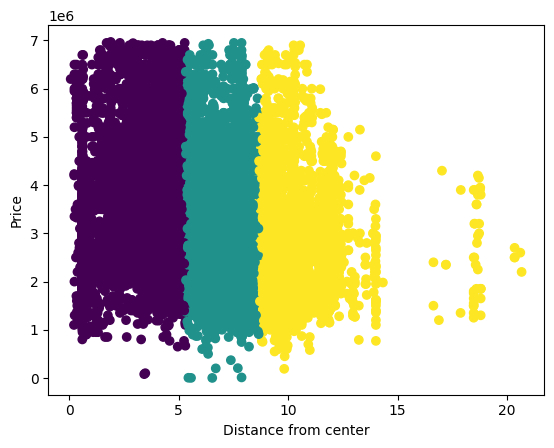

In [27]:

# Выбираем количество кластеров
n_clusters = 3

# Создаем экземпляр класса KMeans
kmeans = KMeans(n_clusters=n_clusters)

# Выбираем столбцы для кластеризации
columns = ["geo_lat", "geo_lon", "center_dist"]

# Выполняем кластеризацию
kmeans.fit(df2[columns])

# Добавляем метки кластеров в датафрейм
df2["cluster"] = kmeans.predict(df2[columns])
# вывод изображения
plt.scatter(df2["center_dist"], df2["price"], c=kmeans.labels_)
plt.xlabel("Distance from center")
plt.ylabel("Price")
plt.show()

In [28]:
#Ниже представлен код для запроса данных от пользователя для предсказания стоимости и кластера

geo_lat = input("Введите широту в формате: 55(два знака до точки).803096(6 после) 45.002575: ")
geo_lon = input("Введите долготу в формате: 55(два знака до точки).803096(6 после) 39.083183: ")
if "," in geo_lat:
    geo_lat = geo_lat.replace(",", ".")
if "," in geo_lon:
    geo_lon = geo_lon.replace(",", ".")
    
building_type = int(input("Введите тип здания (0-другое, 1-монолит, 2-кирпичный, 3-панельный, 4-деревянный): "))
levels = int(input("Введите количество этажей в здании: "))
level= int(input("Введите этаж: "))
rooms = int(input("Введите количество комнат: "))
area = input("Введите общую площадь квартиры (в м2,в формате 40.0): ")
if "," in area:
    area = area.replace(",", ".")
area = float(area)

kitchen_area = input("Введите площадь кухни (в м2,в формате 40.0): ")
if "," in kitchen_area:
    kitchen_area = kitchen_area.replace(",", ".")
kitchen_area = float(kitchen_area)
object_type = int(input("Введите тип объекта (1-вторичное жилье, 11-новостройка): "))
# Создаем новую строку с данными от пользователя
new_data = pd.DataFrame({
    "geo_lat": [float(geo_lat)],
    "geo_lon": [float(geo_lon)],
    "building_type": [building_type],
    "level": [level],
    "levels": [levels],
    "rooms": [rooms],
    "area": [area],
    "kitchen_area": [kitchen_area],
    "object_type": [object_type]
})

# Создаем функцию для вычисления расстояния до центра города
def distance(row):
    point = (row["geo_lat"], row["geo_lon"])
    return round(geopy.distance.distance(center, point).km, 2)

# Вычисляем расстояние до центра города для новой строки
new_data["center_dist"] = new_data.apply(distance, axis=1)

# Нормализуем данные в новой строке
new_data_norm = (new_data[columns] - df2[columns].mean()) / df2[columns].std()

# Определяем кластер, к которому принадлежит новая строка
cluster = kmeans.predict(new_data_norm)
# создаем DataFrame с одной строкой, содержащей введенные значения
new_data = pd.DataFrame([[geo_lat, geo_lon, building_type, level, levels, rooms, area, kitchen_area, object_type]], 
                        columns=['geo_lat', 'geo_lon', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type'])

# используем обученную модель для предсказания цены
price_prediction = rf.predict(new_data)

# выводим предсказанную цену
print("Предсказанная цена:", price_prediction[0])
print("Предсказанный кластер:", cluster[0])

Введите широту в формате: 55(два знака до точки).803096(6 после) 45.002575: 45.2262
Введите долготу в формате: 55(два знака до точки).803096(6 после) 39.083183: 45.9594
Введите тип здания (0-другое, 1-монолит, 2-кирпичный, 3-панельный, 4-деревянный): 0
Введите количество этажей в здании: 12
Введите этаж: 12
Введите количество комнат: 1
Введите общую площадь квартиры (в м2,в формате 40.0): 38
Введите площадь кухни (в м2,в формате 40.0): 6
Введите тип объекта (1-вторичное жилье, 11-новостройка): 1
Предсказанная цена: 2168295.3
Предсказанный кластер: 2


Вывод: На данном этапе проведен анализ корреляции признаков, созданы и обучены и проверены на работоспособность 3 модели предсказания цены на объект недвижимости и одна нейронная сеть, как для масштабированных данных, так и для исходных.Реализована возможность классификации нового объекта на основе предобученной модели кластеризации.  Проведена настройка нейронной сети, результатом которой стало увеличение показателя R^2 с 0,55 до 0,67, что стало возможным благодаря изменению количества эпох обучения, количества слоев и количества нейронов в этих слоях. Также были добавлены "ограничители", чтобы избежать переобучения модели. 
Были созданы графики и гистограммы для дальнейшего исследования. 
Создан код и проверен на работоспособность код, позволяющий пользователю осуществить ввод данных, и посредством мадели предсказания получить вывод предсказанной стоимости объекта недвижимости.

##3 Этап. Оценка качества предсказания моделей и выбор наиболее актуальной
На данном этапе произведем рассмотрение ранее полученных данных:
Из результатов обучения моделей можно сделать следующие выводы:

Модели случайного леса и нейронная сеть демонстрируют наилучшие результаты предсказания цены на недвижимость по сравнению с линейной регрессией и деревом решений, а именно более низкий показатель среднеквадратической ошибки (MSE) и более высокий коэффициент детерминации (R2).

Общая производительность моделей, определенная показателями MSE и R2, может быть улучшена в дальнейшем, с помощью различных методов оптимизации модели, настройки параметров и добавления новых признаков.

Наилучший результат предсказаний  был достигнут моделью случайного леса - R^2: 0.75, поэтому именно она и будет использоваться в дальнейшем. 

Данная модель демонстрирует одинаковые показатели детерминации (R^2) на масштабированных и не масштабированных данных
R^2 представляет собой долю дисперсии зависимой переменной (целевой переменной), которая может быть объяснена моделью, от общей дисперсии зависимой переменной. Значение R^2 находится в диапазоне от 0 до 1, где 0 означает, что модель не объясняет изменчивость целевой переменной, а 1 означает, что модель идеально соответствует данным.

##4 Этап. Развертывание и дальнейшее усовершенствование продукта.
В дальнейшем планируется запуск продукта в качестве Web- страницы, с использованием фреймворка Flask. Пользователь имеет возможность вводить данные в специально отведенные для этого поля, чтобы получить предсказание стоимости на отдельный объект недвижимости и информацию о распределению по кластерам.
Также планируется создание возможности подгрузки своего датасета, с заполненными необходимыми столбцами, для предоставления возможности быстрого предсказания на большом объеме данных. 
Планируется дальнейшая работа, направленная на повышение точности предсказаний, доработка кода, для исключения некорректного ввода на этапе единичного предсказания, дальнейший поиск наиболее предпочтительной модели, а также планируется повторное создание и тестирочание нейронной сети с другими изначальными критериями 
Данный проект размещен в репозитории на Github , по адресу:
###https://github.com/xammax121290/house_price_prediction/tree/main